In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import collections
from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit, StratifiedKFold, cross_val_score

import xgboost as xgb

import optuna

import umap

In [5]:
sub = pd.read_csv("sample_submission.csv")
tr = pd.read_csv("train.csv").drop('ID', axis=1)
te = pd.read_csv("test.csv")
va = pd.read_csv("val.csv").drop('ID', axis=1)

In [ ]:
tr.head()

In [ ]:
va.head()

In [ ]:
te.head()

In [6]:
v_columns = [f'V{i}' for i in range(1,31)]

In [7]:
scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# sclaer = StandardScaler()
scaler.fit(tr[v_columns])
tr[v_columns] = scaler.transform(tr[v_columns])
va[v_columns] = scaler.transform(va[v_columns])

Text(0, 0.5, 'Frequency')

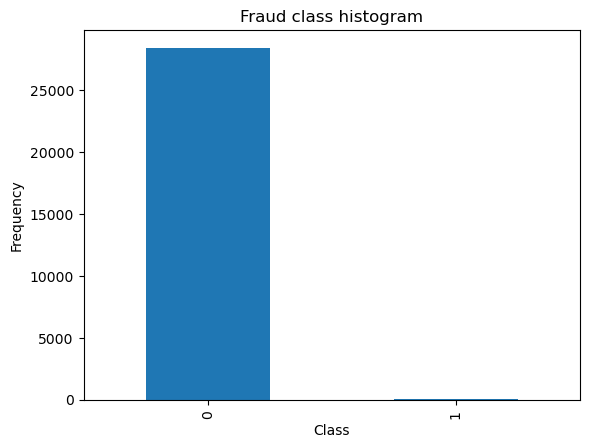

In [8]:
count_classes = pd.value_counts(va['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
vc = va['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(va), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,28432,99.89
1,1,30,0.11


##### 타겟의 imbalace 가 너무 큼 

In [10]:
valid_df = va.sample(frac=1)

fraud_df = valid_df.loc[valid_df['Class'] == 1]
non_fraud_df = valid_df.loc[valid_df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_valid_df = normal_distributed_df.sample(frac=1, random_state=42)

new_valid_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
4396,-0.339312,0.127714,-0.620413,0.474111,-0.371364,-0.063774,-0.484411,0.012600,-0.636450,-0.682273,...,0.058573,-0.016974,0.164750,-0.092124,0.039046,-0.303693,-0.037123,0.009147,-0.486310,1
12377,-0.025012,0.031194,-0.070794,0.113474,0.005907,-0.046207,-0.030840,0.021650,-0.098061,-0.189603,...,-0.069189,-0.004377,-0.115434,0.011507,-0.155335,0.033549,0.005544,-0.001629,-0.085250,1
3415,-0.016233,0.003865,0.044640,0.084731,0.006658,0.003496,0.010287,0.005535,-0.036210,0.001967,...,0.038969,0.003189,0.052300,-0.010938,-0.081376,0.033994,0.006202,0.005268,-0.536450,0
17948,0.033612,-0.010620,-0.014550,0.005244,-0.019141,-0.005997,-0.017810,0.003268,0.111473,-0.000726,...,0.076381,0.001251,-0.099316,-0.020559,0.041743,-0.000477,-0.001529,0.002172,0.448101,0
7702,-0.041407,0.030604,-0.104130,0.132103,-0.084661,0.012110,-0.039382,0.028446,-0.147389,-0.234048,...,0.033466,0.006886,-0.148754,-0.011835,-0.157413,0.063005,0.006115,0.032754,-0.314040,1


In [11]:
print('Distribution of the Classes in the subsample dataset')
print(new_valid_df['Class'].value_counts()/len(new_valid_df))

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


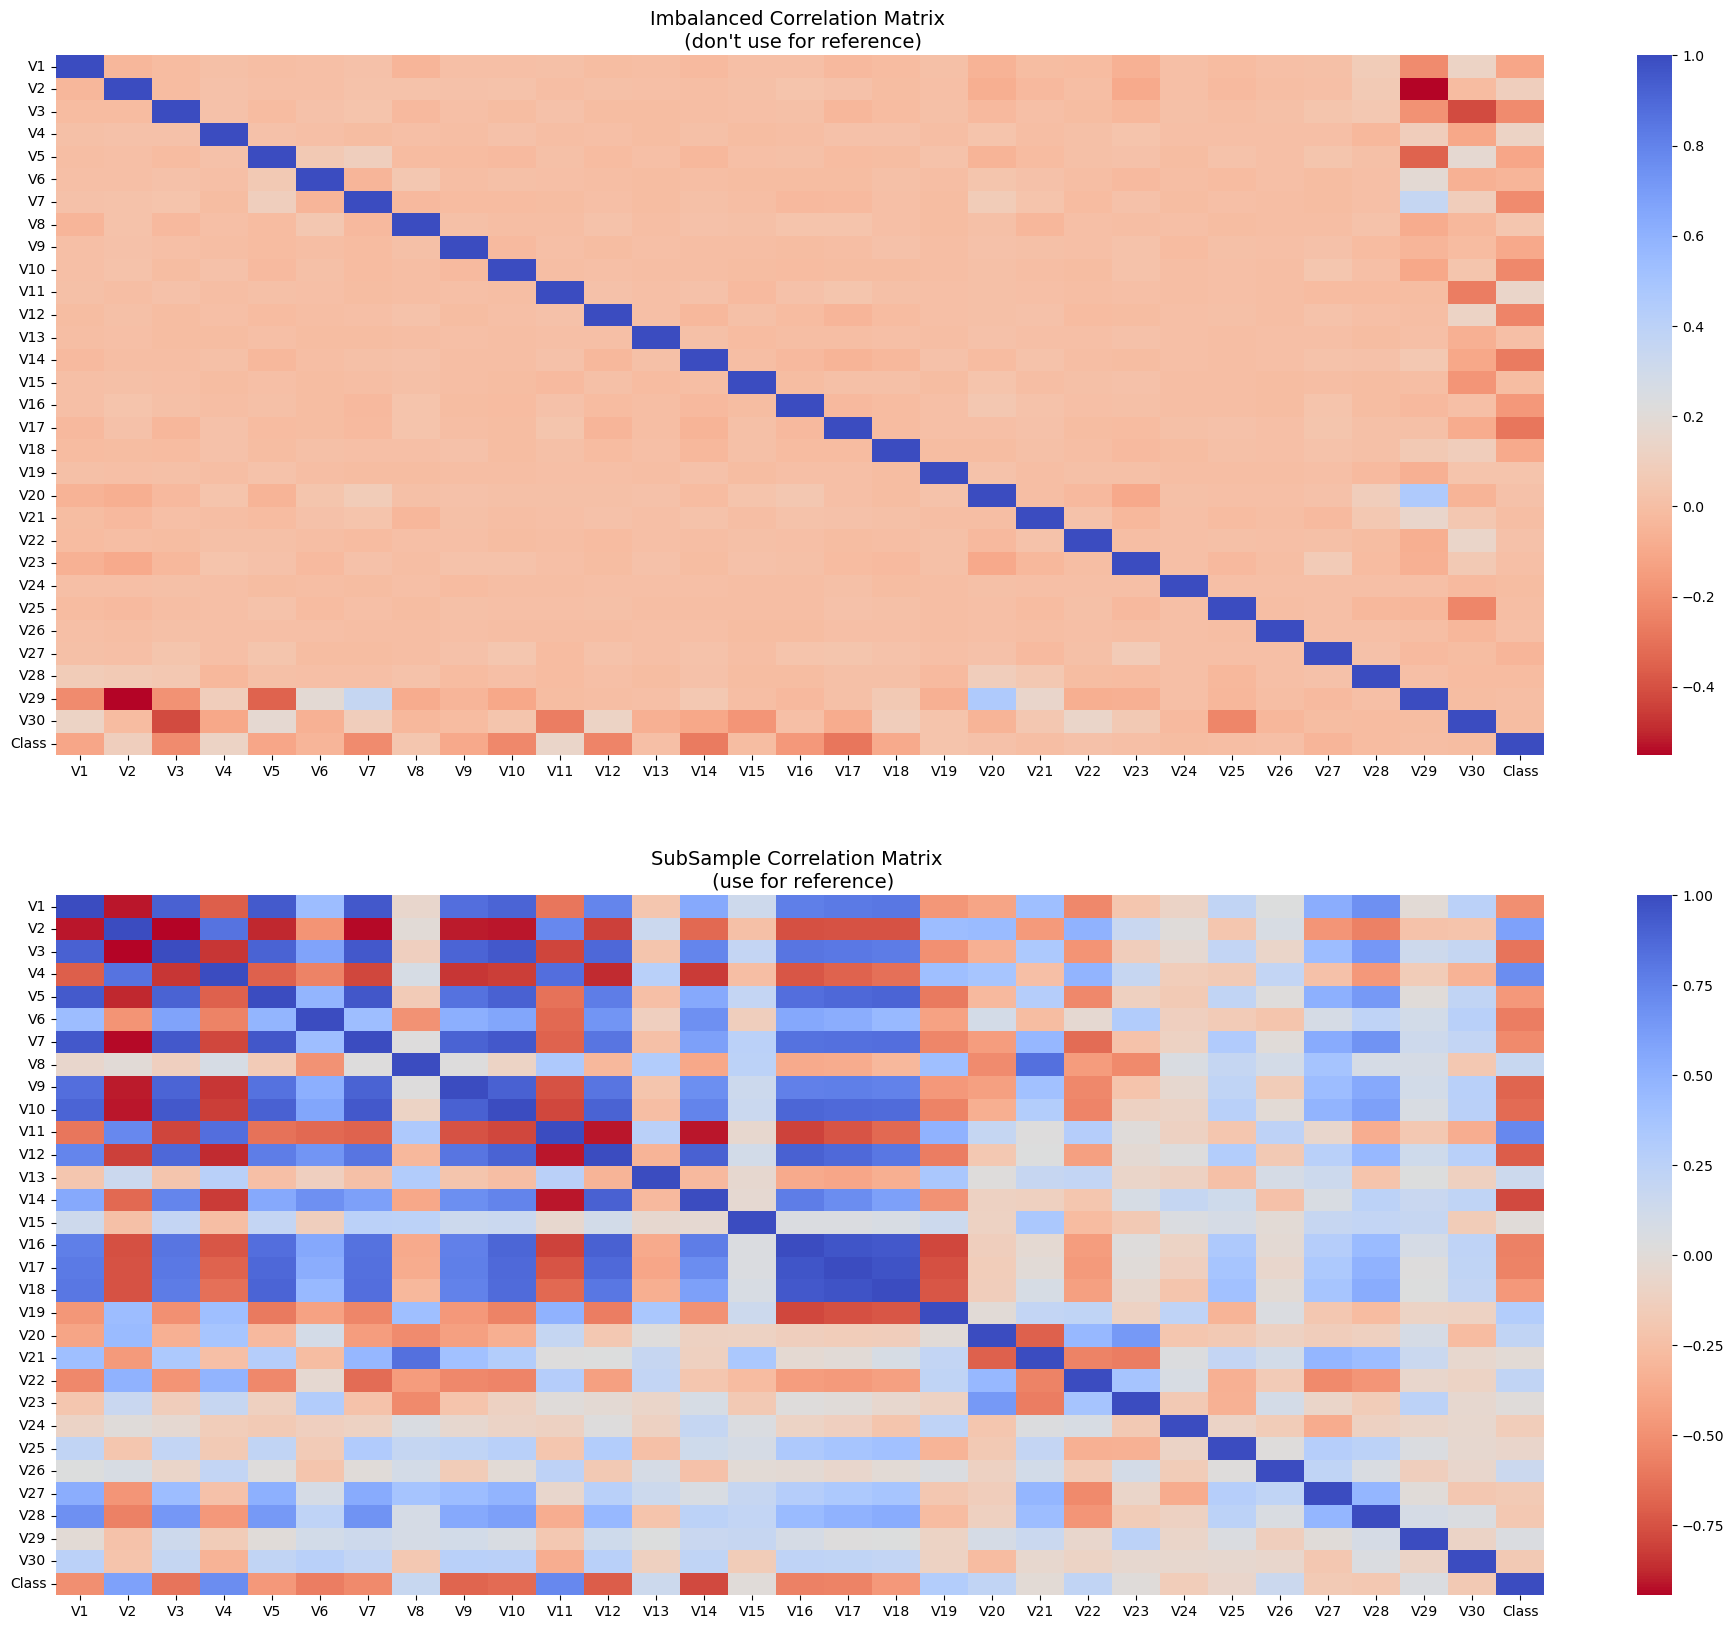

In [12]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = valid_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_valid_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

c:\Users\wjy39\anaconda3\envs\prj\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
c:\Users\wjy39\anaconda3\envs\prj\lib\site-packages\matplotlib\colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


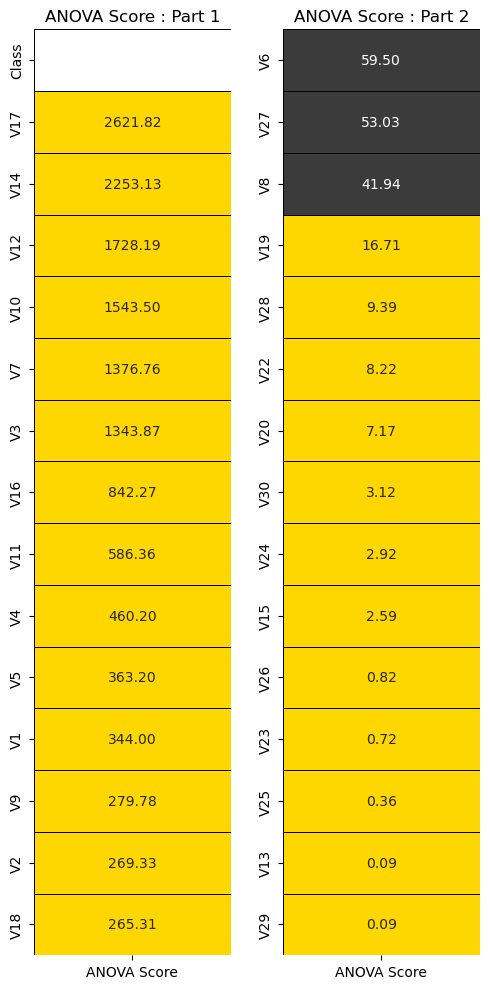

In [15]:
features = va.loc[:,:'Class']
target = va.loc[:,'Class']

colors = ['#FFD700','#3B3B3C']


best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
featureScores = featureScores.sort_values(ascending = False,by = 'ANOVA Score')

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,10))

plt.subplot(1,2,1)
sns.heatmap(featureScores.iloc[:15,:],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False, fmt = '.2f')
plt.title('ANOVA Score : Part 1')

plt.subplot(1,2,2)
sns.heatmap(featureScores.iloc[15:30],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False, fmt = '.2f')
plt.title('ANOVA Score : Part 2')

fig.tight_layout(w_pad = 2)

In [16]:
df1 = va[['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17','Class']].copy(deep = True)
df1.head()

,V1,V2,V3,V4,V5,V7,V10,V11,V12,V14,V16,V17,Class
0,-0.005997,0.015397,0.032180,-0.013473,0.011848,0.014790,-0.015033,0.097409,0.045079,-0.028389,0.055582,-0.025401,0
1,0.017063,0.004517,-0.005284,0.127899,0.026800,0.002445,0.029684,0.161803,0.021924,0.062967,-0.045267,0.018898,0
2,0.020308,0.007908,0.005978,0.157550,-0.002188,0.012067,0.031060,-0.042973,-0.035619,0.050493,0.022204,-0.013517,0
3,0.016435,-0.004451,0.011943,0.033016,0.005855,-0.009706,-0.009240,0.186137,0.074657,0.020109,-0.100250,0.047088,0
4,-0.053277,0.035758,0.045716,-0.146652,0.007268,0.046883,0.247981,0.246247,0.003603,-0.181598,-0.022833,-0.091197,0


In [17]:
# New_df is from the random undersample data (fewer instances)
X = new_valid_df[['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17']].copy(deep = True)
y = new_valid_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca').fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 0.11 s
PCA took 0.0 s
Truncated SVD took 0.002 s


c:\Users\wjy39\anaconda3\envs\prj\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [18]:
train_df = tr[['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17']].copy(deep = True)
valid_df = va[['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17','Class']].copy(deep = True)

In [19]:
use = (['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17'])

In [20]:
scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(train_df[use])
train_df[use] = scaler.transform(train_df[use])
valid_df[use] = scaler.transform(valid_df[use])

In [21]:
fraud_ratio = valid_df['Class'].value_counts()[1]/len(valid_df)
fraud_ratio

0.0010540369615627855

In [22]:
X = valid_df.drop('Class', axis=1).values
y = valid_df['Class'].values

In [23]:
neigh = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='brute', n_jobs=-1)
neigh.fit(X, y)

KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=1,
                     weights='distance')

In [24]:
probs = neigh.predict_proba(train_df.values)
neigh.predict(train_df.values).sum()

123

In [25]:
cnt = 0
train_class = np.zeros(len(train_df), dtype=int)
for idx in np.flip(np.argsort(probs[:,1])):
    cnt += 1
    if probs[idx,1] < 0.5:
        break
    # if probs[idx,1] <= 0:
    #     break
    train_class[idx] = 1
train_df['Class'] = train_class

In [26]:
print(train_df['Class'].value_counts())

# xgboost 학습 파라미터
scale_pos_weight = train_df['Class'].value_counts()[0] / train_df['Class'].value_counts()[1]
print(scale_pos_weight)

0    113719
1       123
Name: Class, dtype: int64
924.5447154471544


In [33]:
train_df

,V1,V2,V3,V4,V5,V7,V10,V11,V12,V14,V16,V17,Class
0,-0.024081,-0.018430,0.054637,0.023029,-0.011939,0.017966,0.008509,0.059779,0.003562,-0.010622,-0.217236,0.052116,0
1,-0.017130,-0.002547,0.055247,-0.052349,-0.000245,0.005394,-0.002252,-0.021680,0.009606,-0.018429,-0.079649,-0.032120,0
2,-0.007552,0.013209,0.035161,-0.010203,0.009988,0.010809,-0.015220,0.128389,0.019397,-0.008778,0.030196,-0.002730,0
3,-0.011422,0.019500,0.033105,-0.029846,0.022514,0.025437,0.051197,-0.059297,0.015710,-0.084737,-0.005722,-0.057383,0
4,-0.015854,0.003935,-0.003488,-0.016465,0.063339,0.008402,-0.016819,-0.067496,-0.005953,0.004759,-0.015791,-0.023466,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-0.221898,0.140105,-0.261189,-0.152231,-0.108823,-0.082455,0.354680,-0.100735,0.152792,0.082467,0.080267,0.027523,0
113838,0.033415,-0.001974,-0.030811,0.091368,-0.000838,0.004318,0.004955,-0.108566,0.036528,0.000129,-0.041340,-0.009388,0
113839,-0.004289,0.009795,0.012319,-0.028100,0.005802,0.021096,-0.011667,-0.058676,-0.003593,0.015230,-0.018453,-0.008210,0
113840,0.002133,0.012803,-0.016824,-0.045181,0.026818,0.018448,-0.026940,0.061726,0.010290,-0.046835,0.045072,0.003307,0


In [27]:
from sklearn.covariance import EllipticEnvelope


In [34]:
train_x = train_df.drop(columns=['Class']) # Input Data

In [35]:
val_normal, val_fraud = valid_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
model = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 42)
model.fit(train_x)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=42,
                 support_fraction=0.994)

In [30]:
valid_df

,V1,V2,V3,V4,V5,V7,V10,V11,V12,V14,V16,V17,Class
0,-0.005997,0.015397,0.032180,-0.013473,0.011848,0.014790,-0.015033,0.097409,0.045079,-0.028389,0.055582,-0.025401,0
1,0.017063,0.004517,-0.005284,0.127899,0.026800,0.002445,0.029684,0.161803,0.021924,0.062967,-0.045267,0.018898,0
2,0.020308,0.007908,0.005978,0.157550,-0.002188,0.012067,0.031060,-0.042973,-0.035619,0.050493,0.022204,-0.013517,0
3,0.016435,-0.004451,0.011943,0.033016,0.005855,-0.009706,-0.009240,0.186137,0.074657,0.020109,-0.100250,0.047088,0
4,-0.053277,0.035758,0.045716,-0.146652,0.007268,0.046883,0.247981,0.246247,0.003603,-0.181598,-0.022833,-0.091197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.009686,0.019721,-0.009652,0.056154,0.012394,0.024199,-0.003186,0.051182,0.040321,0.065192,-0.068714,0.006733,0
28458,-0.013554,0.008091,-0.027966,-0.025398,0.021390,0.017218,-0.051022,0.083692,0.008769,-0.020341,0.036294,0.031994,0
28459,-0.007924,0.017908,-0.005194,0.059521,0.013736,0.028452,0.003139,-0.123600,-0.037236,0.048228,-0.084930,0.014981,0
28460,0.036158,-0.002410,-0.036877,0.014225,-0.000207,0.000387,0.010973,0.050093,0.030131,0.040082,0.016940,-0.028418,0


In [31]:
import torch
from sklearn.metrics import confusion_matrix

In [36]:
def get_pred_label(model, x, k):
  prob = model.score_samples(x)
  prob = torch.tensor(prob, dtype = torch.float)
  topk_indices = torch.topk(prob, k = k, largest = False).indices

  pred = torch.zeros(len(x), dtype = torch.long)
  pred[topk_indices] = 1
  return pred.tolist(), prob.tolist()

val_x = valid_df.drop(columns=['Class']) # Input Data
val_y = valid_df['Class'] # Label

val_pred, val_prob = get_pred_label(model, val_x, 29)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))
tn, fp, fn, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.7709490362991742]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.55      0.53      0.54        30

    accuracy                           1.00     28462
   macro avg       0.78      0.77      0.77     28462
weighted avg       1.00      1.00      1.00     28462

tp :  16 , fp :  13 , tn :  28419 , fn :  14


## test set

In [37]:
te.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [40]:
test_x = te.drop(columns=['ID'])
test_x = test_x[['V1','V2','V3','V4','V5','V7','V10','V11','V12','V14','V16','V17']].copy(deep = True)

In [41]:
test_pred, _ = get_pred_label(model, test_x, 318)
print('n_fraud : ', sum(test_pred))

n_fraud :  318


In [42]:
sub.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [43]:
sub['Class'] = test_pred
sub.to_csv('sample_submission.csv', index=False)

In [44]:
pd.read_csv('sample_submission.csv')['Class'].sum()

318